## SC3251 - Term Project
**Name:** Hussary, Elias   
**Assignment:** SC3251 - Term Project
**Date:** 2018-08-07

---

## Objective
- Explore the "chickweight.csv" dataset. 
- Create an OLS Model for each diet in the Chick Weight dataset.

---

In [2]:
%config IPCompleter.greedy=True # for better intellisense
import statsmodels.api as sm
from matplotlib import pyplot as plt, rcParams
import pandas as pd
rcParams.update({'font.size': 16, 'figure.figsize': (10,6)}) # global formatting

C:\Users\elias\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Load the data set for initial analysis.

In [3]:
cw = pd.read_csv('./chickweight.csv', index_col=0)
cw

weight  Time  Chick  Diet
rownum                           
1           42     0      1     1
2           51     2      1     1
3           59     4      1     1
4           64     6      1     1
5           76     8      1     1
6           93    10      1     1
7          106    12      1     1
8          125    14      1     1
9          149    16      1     1
10         171    18      1     1
11         199    20      1     1
12         205    21      1     1
13          40     0      2     1
14          49     2      2     1
15          58     4      2     1
16          72     6      2     1
17          84     8      2     1
18         103    10      2     1
19         122    12      2     1
20         138    14      2     1
21         162    16      2     1
22         187    18      2     1
23         209    20      2     1
24         215    21      2     1
25          43     0      3     1
26          39     2      3     1
27          55     4      3     1
28          67     6      3     1
29          84     8      3     1
30          99    10      3     1
...        ...   ...    ...   ...
549        154    12     48     4
550        170    14     48     4
551        222    16     48     4
552        261    18     48     4
553        303    20     48     4
554        322    21     48     4
555         40     0     49     4
556         53     2     49     4
557         64     4     49     4
558         85     6     49     4
559        108     8     49     4
560        128    10     49     4
561        152    12     49     4
562        166    14     49     4
563        184    16     49     4
564        203    18     49     4
565        233    20     49     4
566        237    21     49     4
567         41     0     50     4
568         54     2     50     4
569         67     4     50     4
570         84     6     50     4
571        105     8     50     4
572        122    10     50     4
573        155    12     50     4
574        175    14     50     4
575        205    16     50     4
576        234    18     50     4
577        264    20     50     4
578        264    21     50     4

[578 rows x 4 columns]

### Exploring The Data

In [4]:
# normalize col names
cw.columns = ['weight', 'time', 'chick', 'diet']
cw.describe()

weight        time       chick        diet
count  578.000000  578.000000  578.000000  578.000000
mean   121.818339   10.717993   25.750865    2.235294
std     71.071960    6.758400   14.568795    1.162678
min     35.000000    0.000000    1.000000    1.000000
25%     63.000000    4.000000   13.000000    1.000000
50%    103.000000   10.000000   26.000000    2.000000
75%    163.750000   16.000000   38.000000    3.000000
max    373.000000   21.000000   50.000000    4.000000

#### Plotting
Lets first plot our data and see how it looks.

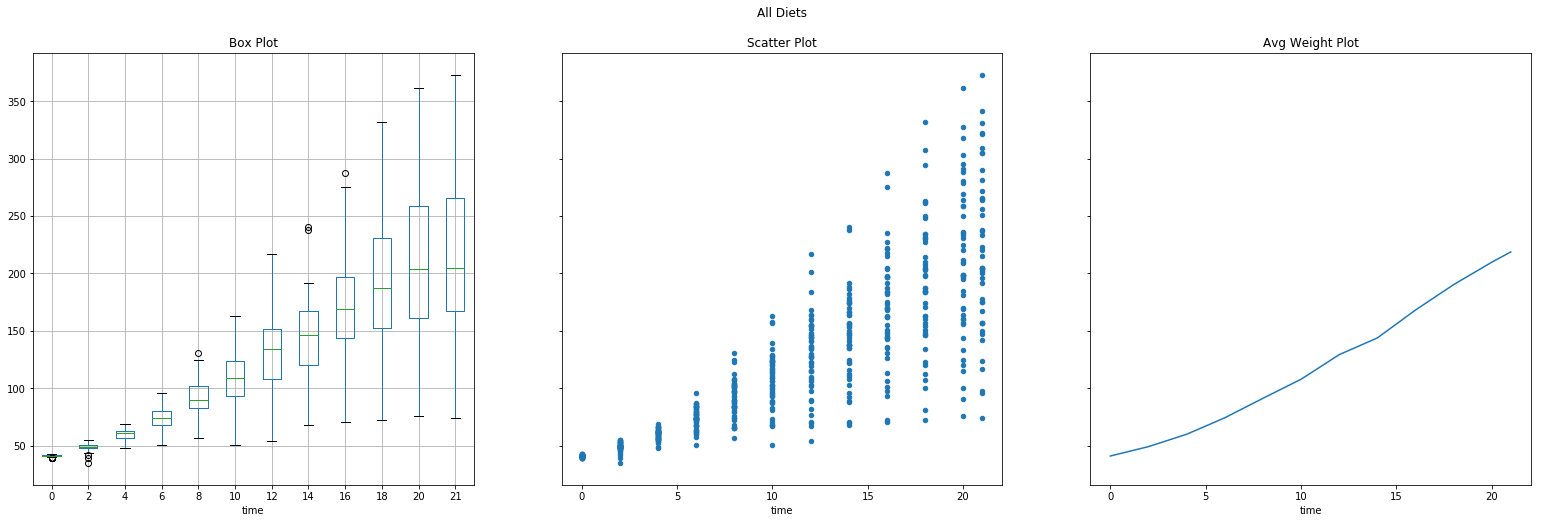

In [5]:
def plotByTimeAndWeight(df, title=''):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(26,8), sharey=True) 
    
    # boxplot
    df.boxplot(column='weight', by='time', ax=ax[0])
    plt.ylabel('weight')
    ax[0].set_title('Box Plot')
    
    # scatter
    df.plot.scatter(x='time', y='weight',ax=ax[1])
    ax[1].set_title('Scatter Plot')

    # avg line graph
    df_avg = df['weight'].groupby([cw.time]).mean()
    df_avg.plot.line(ax=ax[2])
    ax[2].set_title('Avg Weight Plot')

    plt.suptitle(title)

    
plotByTimeAndWeight(cw, title='All Diets')

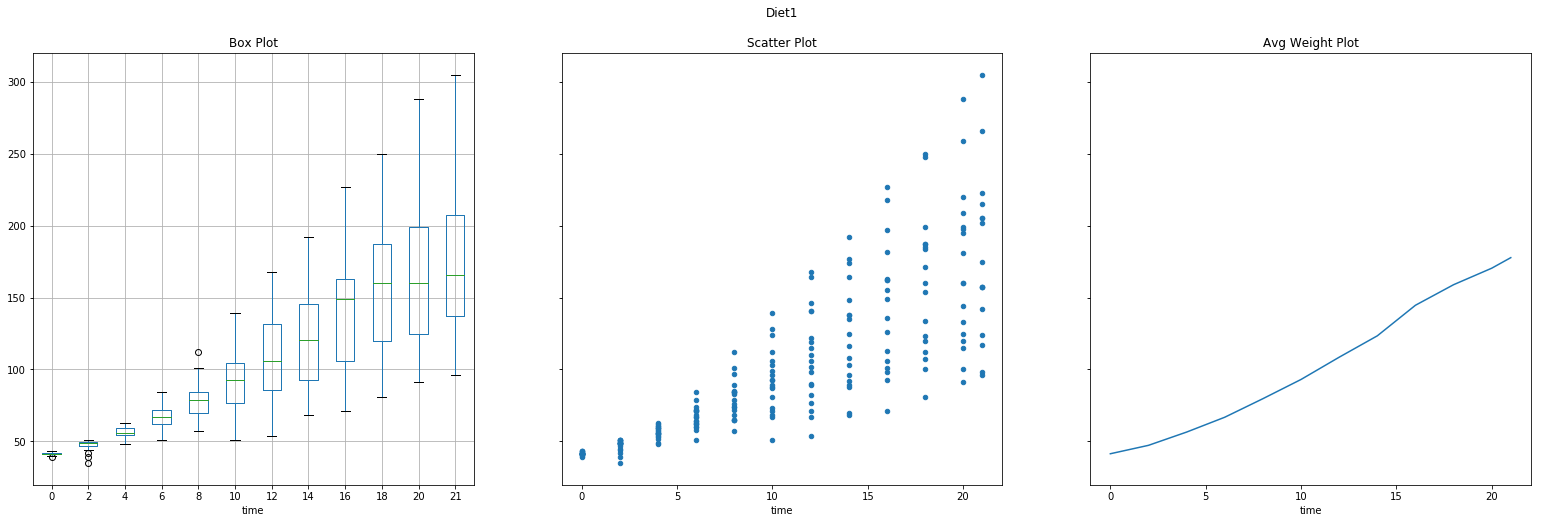

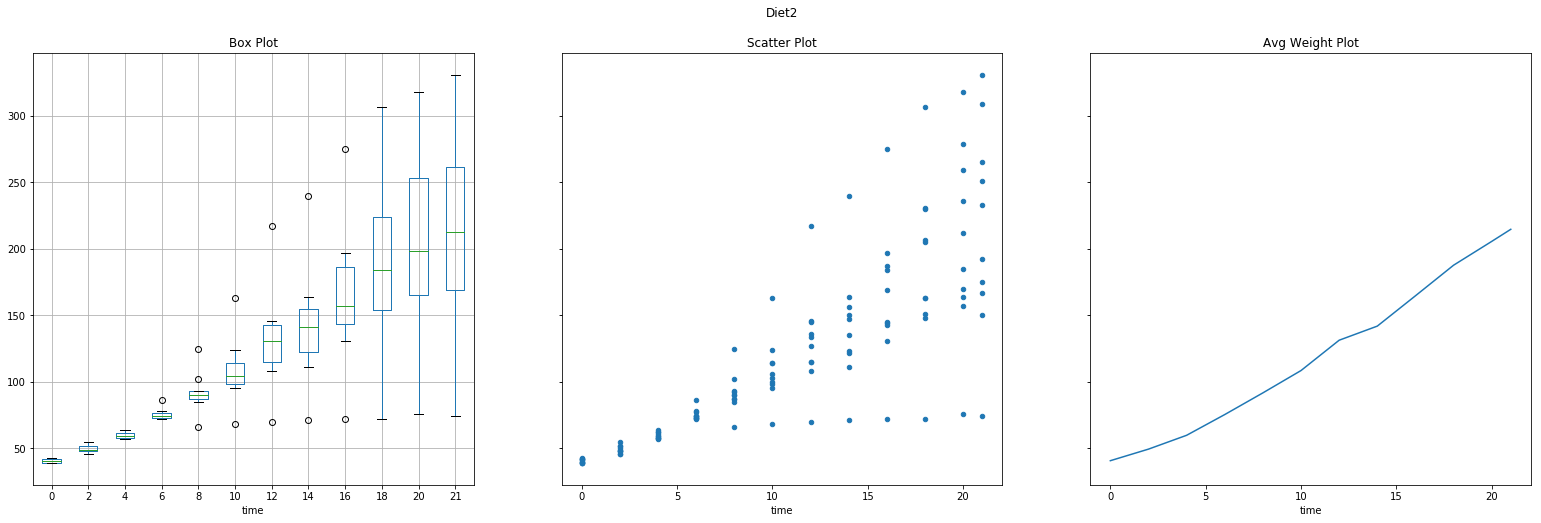

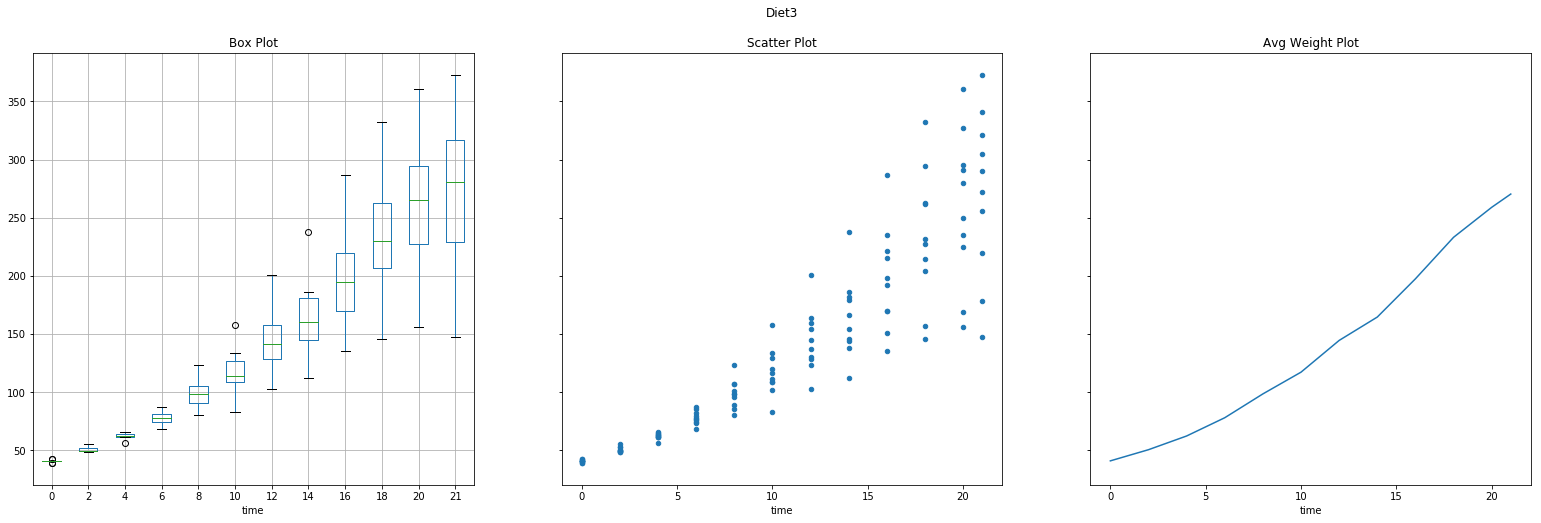

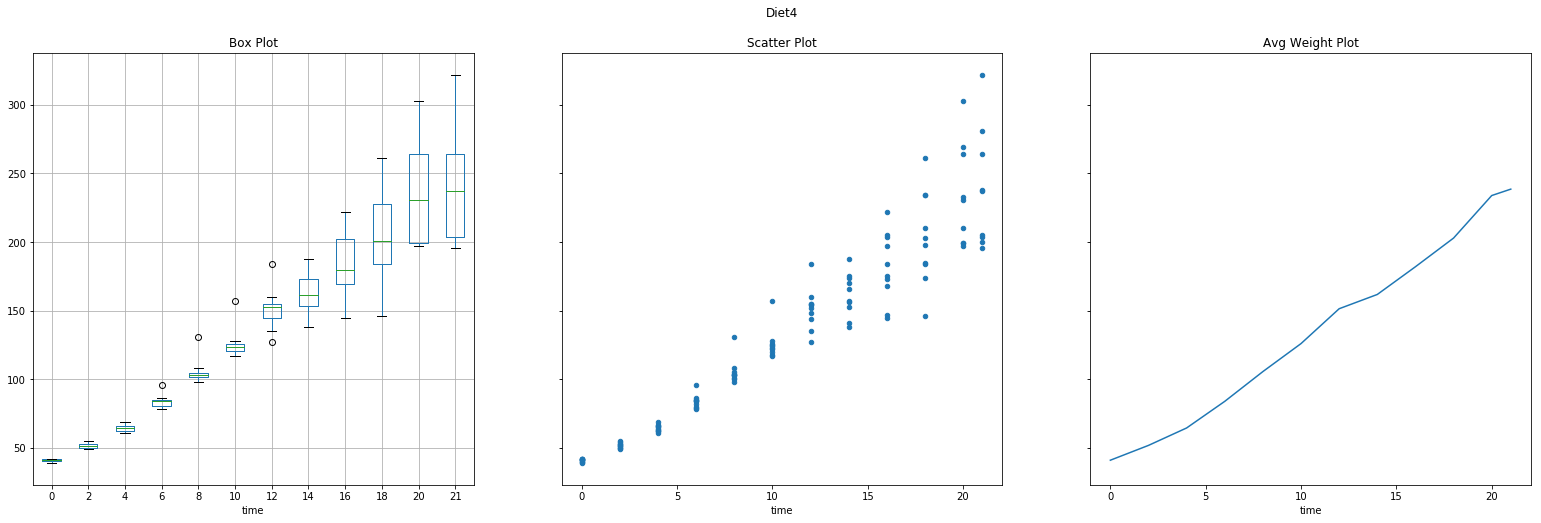

In [6]:
for d in cw.diet.unique():
    plotByTimeAndWeight(cw[(cw.diet == d)], title='Diet' + str(d))

#### Initial Observations
**Diet1:** Appears to be mostly linear, but the data is pretty sparse.  
**Diet2:** There appears to be some outliers here. We observe a chick plateauing in weight on the low end, and a chick gaining weight rapidly.  
**Diet3:** At quick glance it appears Diet3 proves to be most effective in weight gain, but not the most consistent.  
**Diet4:** Diet 4 appears to be most consistent, with the least variability.   


Let's observe Avg Weight / Time by Diet on a single graph to determine which diet is most effective in weight gain.

Text(0.5,1,'Avg Weight / Time by Diet')

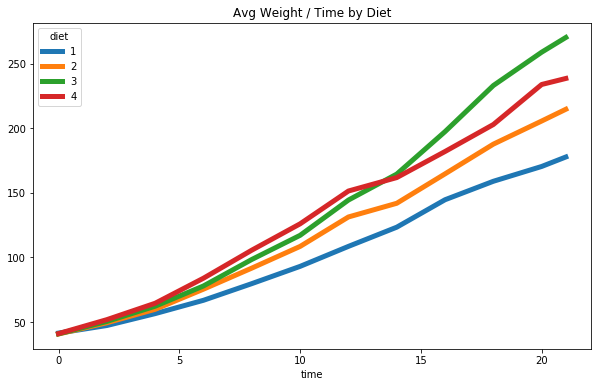

In [18]:
avg_by_diet = cw['weight'].groupby([cw.time, cw.diet]).mean()
avg_by_diet.unstack().plot.line(figsize=(10,6), linewidth=5)
plt.title("Avg Weight / Time by Diet")

In [20]:
avg_by_diet.unstack().describe()

diet            1           2           3           4
count   12.000000   12.000000   12.000000   12.000000
mean   105.692934  122.616667  142.950000  136.945370
std     48.967637   61.215830   81.812352   69.117174
min     41.400000   40.700000   40.800000   41.000000
25%     64.210526   71.500000   73.975000   79.050000
50%    100.789474  119.900000  130.750000  138.700000
75%    148.220588  170.450000  206.325000  187.225000
max    177.750000  214.700000  270.300000  238.555556

On average it appears that **Diet3** is in fact the most effective for weight gain, and **Diet4** is a near second.

### Performing the Linear Regression
We will perform a Linear Regression on each Diet and on the cumulative data.

In [172]:
# define helper functions
def create_model(df, xcol, ycol, title):
    x = df[xcol]
    y = df[ycol]
    sm_model = sm.OLS(y, sm.add_constant(x)).fit()
    residuals = y - sm_model.predict(sm.add_constant(x)) 
    
    return {
        'name': title,
        'model': sm_model,
        'residuals': residuals,
        'df': df,
        'x': x,
        'y': y
    }

def plot_regression(model):
    intercept, slope = model['model'].params
    x = model['x']
    y = model['y']
    plt.title(model['name'] + ' - Linear Regression')
    plt.plot(x, y, 'o', label='data_point', markersize=5)
    plt.plot(x, intercept + slope * x, 'r-', label='fitted_line')
    plt.legend()
    
    
def plot_residuals(model):
    
    #destructure
    residuals, name, sm_model =  model['residuals'], model['name'], model['model']
    y, X = model['y'], model['x']
        
    #plot
    plt.figure(figsize=(24,6))
    
    #regression
    plt.subplot(131)
    plot_regression(model)
    
    # histogram
    plt.subplot(132)
    plt.hist(residuals, bins=10)
    plt.title(name + ' - Histogram')
    
    # residuals v predictor
    plt.subplot(133)
    plt.plot(X, residuals, 'o')
    plt.axhline(y=0, color='r', linestyle='-')
    plt.title(name + ' - Residuals vs Predictor')
    
    print(sm_model.summary())

### All Diets OLS

Lets perform a linear regression on the whole dataset to see what we get.

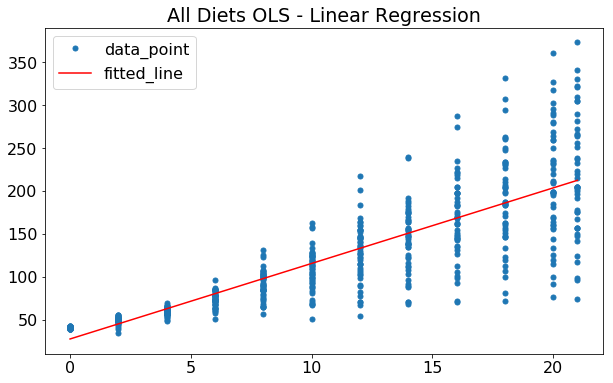

In [173]:
m_all_diets = create_model(cw, 'time', 'weight', 'All Diets OLS')

plot_regression(m_all_diets)

                            OLS Regression Results                            
Dep. Variable:                 weight   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     1349.
Date:                Mon, 06 Aug 2018   Prob (F-statistic):          5.02e-153
Time:                        18:22:10   Log-Likelihood:                -2935.4
No. Observations:                 578   AIC:                             5875.
Df Residuals:                     576   BIC:                             5884.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.4674      3.036      9.046      0.0

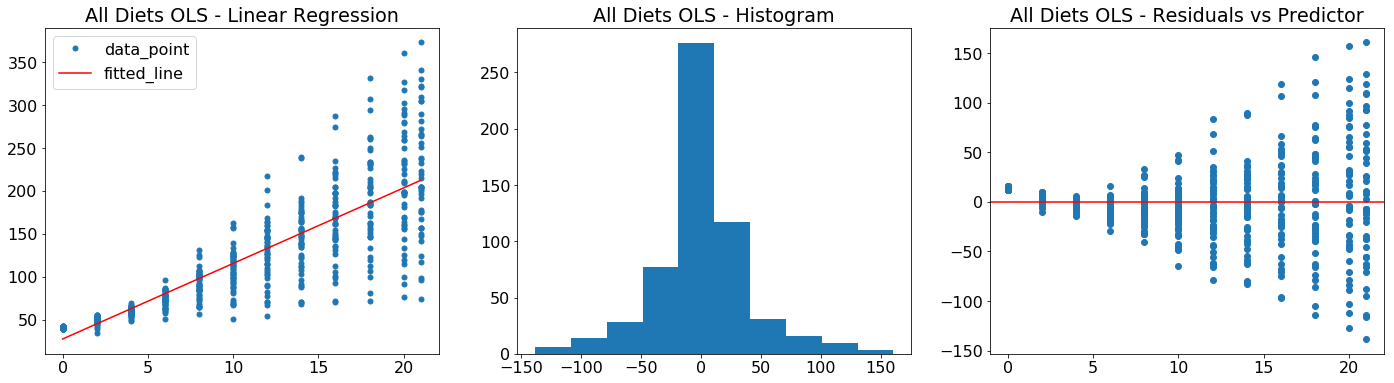

In [174]:
plot_residuals(m_all_diets)

In [189]:
m_all_diets['model'].predict(exog=(1,50))[0] # out of curiosity, lets predict weight at 50 days

467.61938853461515

#### All Diets OLS Observations
While the residuals are normally distributed, and the residuals vs predictor comparison are constant, it appears there is great variance when viewing the data scattered.

R-squared is 70% which isn't bad considering this is all 4 diets at once.

Let's run a regression on the individual diets in hopes for more consistent models.

### Diet 1

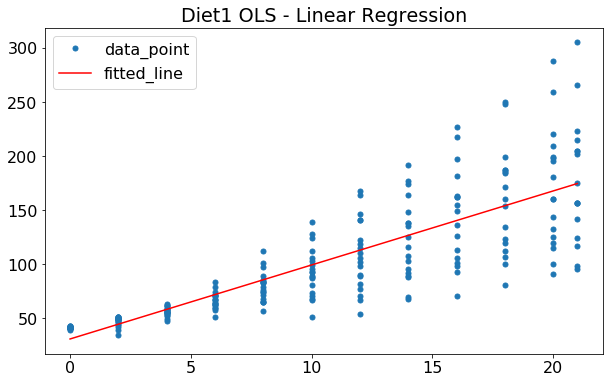

In [231]:
m_d1 = create_model(cw[(cw.diet == 1)], 'time', 'weight', 'Diet1 OLS')

plot_regression(m_d1)

                            OLS Regression Results                            
Dep. Variable:                 weight   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     433.5
Date:                Mon, 06 Aug 2018   Prob (F-statistic):           9.81e-54
Time:                        19:18:03   Log-Likelihood:                -1079.4
No. Observations:                 220   AIC:                             2163.
Df Residuals:                     218   BIC:                             2170.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.9310      4.095      7.554      0.0

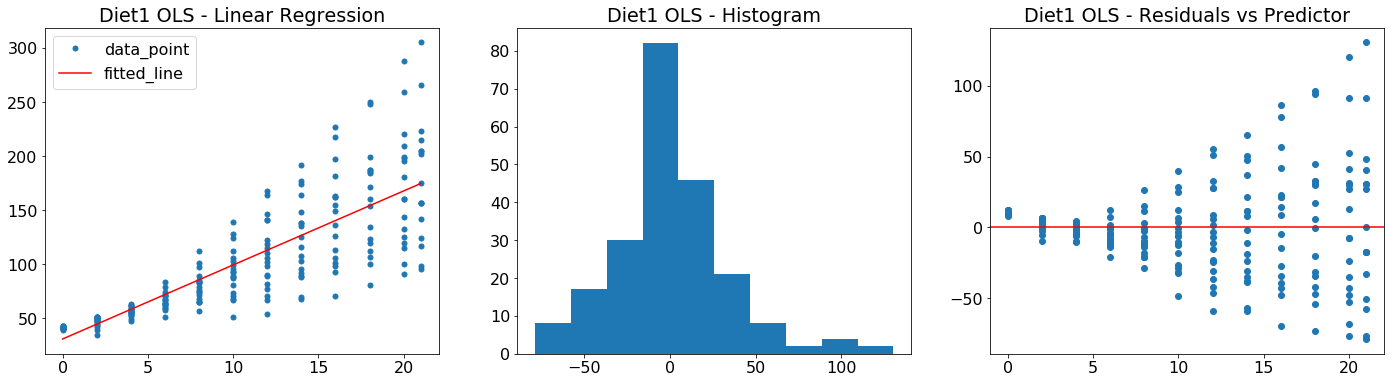

In [232]:
plot_residuals(m_d1)

#### Diet1 OLS Observations
Diet1 is very similar to the whole data set model but the data points are more sparse. No surprises here.

R-Squared is lower than the whole data set. While the linear model works, our readings may not always be accurate.

### Diet2

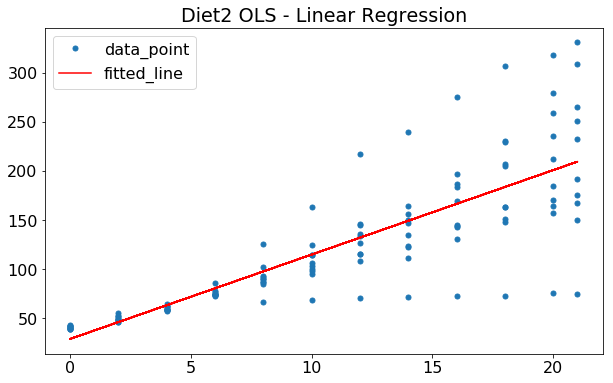

In [233]:
m_d2 = create_model(cw[(cw.diet == 2)], 'time', 'weight', 'Diet2 OLS')

plot_regression(m_d2)

                            OLS Regression Results                            
Dep. Variable:                 weight   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.666
Method:                 Least Squares   F-statistic:                     238.7
Date:                Mon, 06 Aug 2018   Prob (F-statistic):           4.04e-30
Time:                        19:18:43   Log-Likelihood:                -615.94
No. Observations:                 120   AIC:                             1236.
Df Residuals:                     118   BIC:                             1241.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.6336      7.160      3.999      0.0

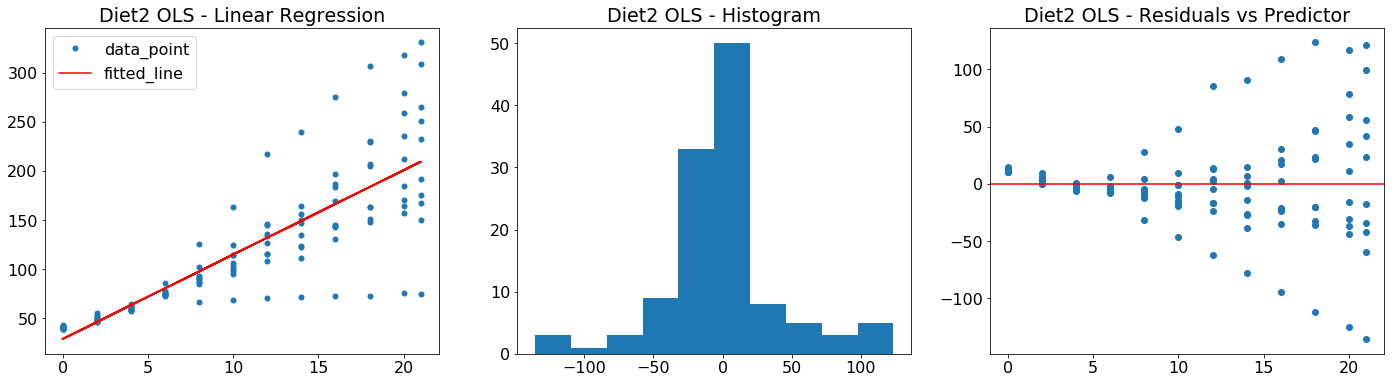

In [234]:
plot_residuals(m_d2)

#### Diet2 OLS Observations
Diet2 has what appears to be a better fit for the majority of the dataset. There does appear to be 2 outliers, both on the high end and low end of the spectrum.

R-Squared indicates that this model isn't too far off from D1 and the whole data set.

### Diet3

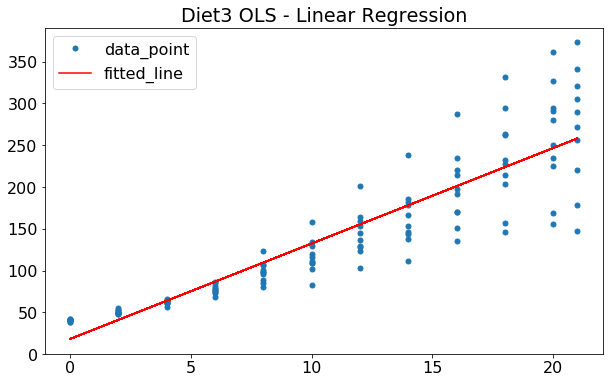

In [203]:
m_d3 = create_model(cw[(cw.diet == 3)], 'time', 'weight', 'Diet3 OLS')

plot_regression(m_d3)

                            OLS Regression Results                            
Dep. Variable:                 weight   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     492.0
Date:                Mon, 06 Aug 2018   Prob (F-statistic):           6.56e-44
Time:                        18:48:59   Log-Likelihood:                -606.48
No. Observations:                 120   AIC:                             1217.
Df Residuals:                     118   BIC:                             1223.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.2503      6.617      2.758      0.0

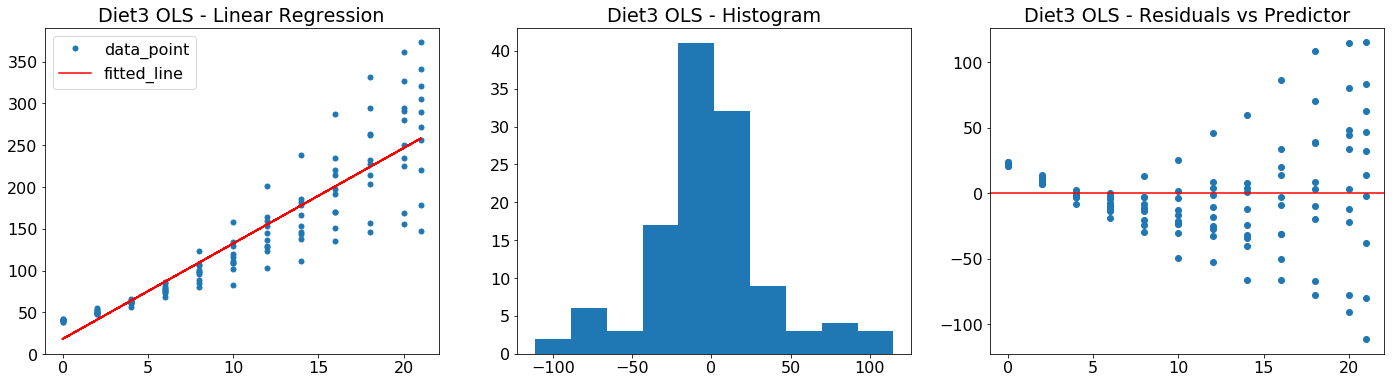

In [204]:
plot_residuals(m_d3)

#### Diet3 OLS Observations
Diet3 was the most effective in terms of weight gain, and compared to the other two diets thus far it appears to be the most consistent for an OLS model.

R-Squared is 0.80, quite a jump up from the other models thus far.

### Diet4

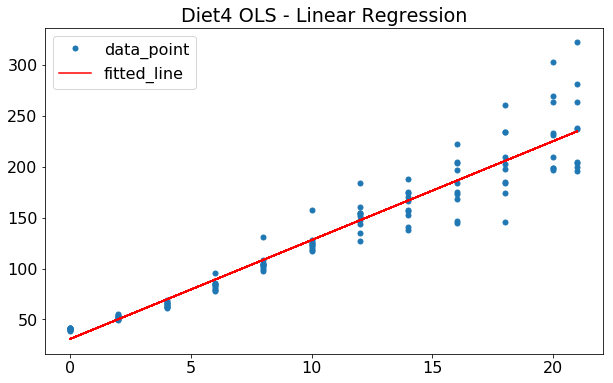

In [206]:
m_d4 = create_model(cw[(cw.diet == 4)], 'time', 'weight', 'Diet4 OLS')

plot_regression(m_d4)

                            OLS Regression Results                            
Dep. Variable:                 weight   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     1119.
Date:                Mon, 06 Aug 2018   Prob (F-statistic):           2.04e-61
Time:                        18:54:57   Log-Likelihood:                -526.71
No. Observations:                 118   AIC:                             1057.
Df Residuals:                     116   BIC:                             1063.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.7921      3.682      8.363      0.0

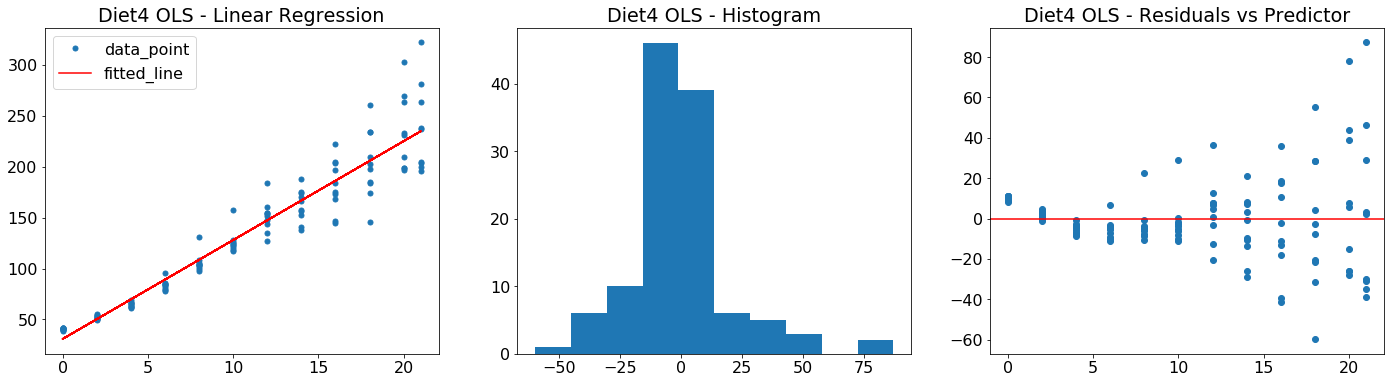

In [207]:
plot_residuals(m_d4)

#### Diet4 OLS Observations
Diet4 appears to be the most consistent diet in regards to the data points.

R-Squared 

### Additional Visualizations

Text(0.5,1,'Linear Regression')

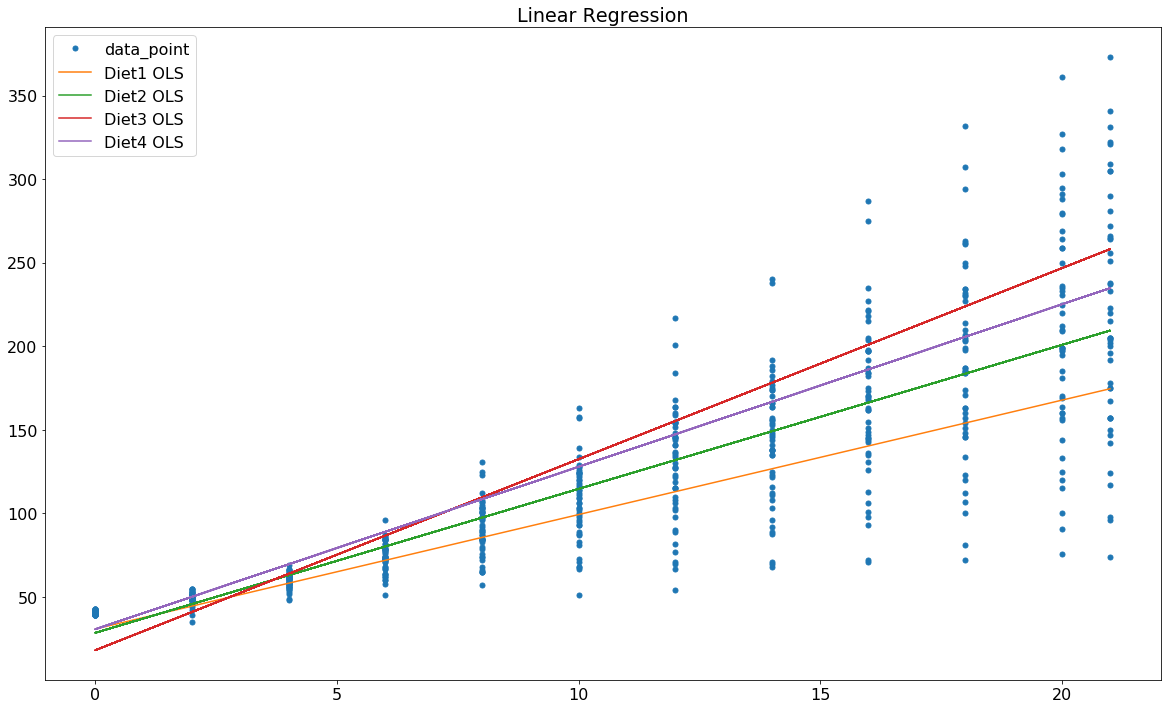

In [238]:
plt.figure(figsize=(20,12))
plt.plot(cw['time'], cw['weight'], 'o', label='data_point', markersize=5)
for m in [m_d1, m_d2, m_d3, m_d4]:
    intercept, slope = m['model'].params
    x = m['x']
    y = m['y']
    plt.plot(x, intercept + slope * x, label=m['name'])
plt.legend()
plt.title('Linear Regression')